In [10]:
from pathlib import Path
import os
def load_env_vars_from_file(path: Path):
    file = path.read_text()
    for line in file.splitlines():
        if line.startswith("export"):
            var_to_value = line.split(" ")[1].split("=")
            var_ = var_to_value[0]
            value_ = var_to_value[1][1:-1]
            os.environ[var_] = value_
def set_up_prod_credentials():
    file = "../../../../scripts/prod_setup_creds.sh"
    load_env_vars_from_file(Path(file))
set_up_prod_credentials()

In [8]:
import json
predictions = json.load(open("/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/weather_predictions.json"))

In [3]:
# Looks like 2024-04-04
days = []
# Max temp samples for day
samples = []
for pred in predictions:
    days.append(pred[0].split(" ")[0])
    samples.append([round(p) for p in pred[1]])

In [25]:
from helpers.types.markets import Market
def get_market_range_temp_values(market: Market):
    if market.strike_type == "greater":
        return (market.floor_strike, 1000000000)
    if market.strike_type == "less":
        return (0, market.cap_strike)
    return (market.floor_strike, market.cap_strike + 1)

In [31]:
from datetime import datetime
from data.coledb.coledb import ColeDBInterface
from exchange.interface import ExchangeInterface
from helpers.types.markets import GetMarketsRequest, MarketStatus, MarketResult
from helpers.types.money import get_opposite_side_price
import pytz

from helpers.types.orderbook import OrderbookView
utc_zone = pytz.utc
eastern_zone = pytz.timezone("US/Eastern")
e = ExchangeInterface(is_test_run=False)
db = ColeDBInterface()
data = {}
for day, samples_ in list(zip(days, samples)):
    # Get market history at timestamp 9:05
    date_object = datetime.strptime(day, "%Y-%m-%d")
    
    date_with_time = datetime(date_object.year, date_object.month,date_object.day, 14, 5)
    # Localize the UTC time
    date_with_time = utc_zone.localize(date_with_time)
    # Convert to Eastern Time
    date_with_time = date_with_time.astimezone(eastern_zone)
    event_ticker = "HIGHNY-" + date_object.strftime("%y%b%d").upper()
    markets = list(e.get_markets(GetMarketsRequest(event_ticker=event_ticker)))
    ticker_to_market = {m.ticker: m for m in markets}
    if len(markets) == 0:
        print("no markets found on this day")
        continue
    ranges_ = []
    tickers = []
    for market in markets:
        range_ = get_market_range_temp_values(market)
        ranges_.append(range_)
        tickers.append(market.ticker)
    ranges_and_tickers = sorted(zip(ranges_,tickers), key= lambda x: x[0][0])
    # Cap price
    top_bounds = [x[0][1] for x in ranges_and_tickers]
    lower_bounds = [x[0][0] for x in ranges_and_tickers]
    tickers = [x[1] for x in ranges_and_tickers]
    samples_ = sorted(samples_)
    dist = [0] * len(tickers)
    i = 0 
    for j, top_bound in enumerate(top_bounds):
        while i < len(samples_):
            sample = round(samples_[i])
            if sample < top_bound:
                dist[j] += 1
                i += 1
            else:
                break
    probs = [int(round(dist[i] / sum(dist), 2)*100) for i in range(len(dist))]
    profit = 0
    data[day] = {"markets": []}
    for i, ticker in enumerate(tickers):
        predicted_prob = probs[i]
        try:
            ob = list(db.read(ticker, end_ts=date_with_time))[-1]
        except:
            del data[day]
            break
        bbo = ob.get_bbo()
        ob = ob.get_view(OrderbookView.ASK)
        result = ticker_to_market[ticker].result
        data[day]["markets"].append({"temp_floor": lower_bounds[i], "temp_ceil": top_bounds[i], "outcome": result.value, "orderbook": {"yes_ask": ob.yes.levels, "no_ask": ob.no.levels}})
        if bbo.ask:
            if predicted_prob > bbo.ask.price:
                result_revenue = 100 if result == MarketResult.YES else 0
                print(result_revenue, result, bbo.ask.price)
                profit += result_revenue - bbo.ask.price
            elif bbo.bid:
                if (100 - predicted_prob) > (no_price := get_opposite_side_price(bbo.bid.price)):
                    result_revenue = 100 if result == MarketResult.NO else 0
                    print(result_revenue, result, no_price)
                    profit += result_revenue - no_price
    print(profit, day)
import json
with open("market_data.json", mode="w") as f:
    json.dump(data, f)



100 MarketResult.NO 82¢
100 MarketResult.NO 47¢
100 MarketResult.NO 85¢
86 2024-04-04
0 MarketResult.NO 1¢
0 MarketResult.NO 12¢
0 MarketResult.YES 77¢
100 MarketResult.NO 50¢
100 MarketResult.NO 83¢
100 MarketResult.NO 96¢
-19 2024-04-05
0 2024-04-08
0 2024-04-09
0 MarketResult.NO 1¢
0 MarketResult.NO 1¢
0 MarketResult.NO 1¢
100 MarketResult.NO 93¢
0 MarketResult.YES 72¢
-68 2024-04-10
0 MarketResult.NO 14¢
100 MarketResult.NO 75¢
11 2024-04-11
0 MarketResult.NO 10¢
-10 2024-04-12
0 2024-04-15
0 2024-04-16
0 2024-04-17
0 2024-04-18
0 2024-04-19
0 MarketResult.NO 1¢
100 MarketResult.NO 65¢
0 MarketResult.NO 31¢
0 MarketResult.YES 81¢
-78 2024-04-22
0 MarketResult.NO 1¢
0 MarketResult.YES 77¢
-78 2024-04-23
0 MarketResult.NO 3¢
0 MarketResult.NO 11¢
0 MarketResult.NO 28¢
0 MarketResult.YES 31¢
-73 2024-04-24
0 MarketResult.YES 66¢
-66 2024-04-25
0 MarketResult.NO 1¢
0 MarketResult.NO 12¢
100 MarketResult.NO 70¢
100 MarketResult.NO 72¢
0 MarketResult.YES 85¢
-40 2024-04-26
0 MarketResult

In [30]:
print(day)

2024-05-24


In [26]:
# This code can help you graph the expiration values
from datetime import datetime
from data.coledb.coledb import ColeDBInterface
from exchange.interface import ExchangeInterface
from helpers.types.markets import GetMarketsRequest, MarketStatus, MarketResult
from helpers.types.money import get_opposite_side_price
import pytz
import matplotlib.pyplot as plt
import json
predictions = json.load(open("/Users/kamyarghiam/Desktop/kalshi_bot/src/data/local/research/weather_predictions.json"))


from helpers.types.orderbook import OrderbookView
utc_zone = pytz.utc
eastern_zone = pytz.timezone("US/Eastern")
e = ExchangeInterface(is_test_run=False)
db = ColeDBInterface()
data = {}
date_to_max_temp = dict()
def print_hists():
    for pred in predictions:
        samples = pred[1]
        day =pred[0].split(" ")[0]
        print(day)
        # Get market history at timestamp 9:05
        date_object = datetime.strptime(day, "%Y-%m-%d")
        
        date_with_time = datetime(date_object.year, date_object.month,date_object.day, 14, 5)
        # Localize the UTC time
        date_with_time = utc_zone.localize(date_with_time)
        # Convert to Eastern Time
        date_with_time = date_with_time.astimezone(eastern_zone)
        event_ticker = "HIGHNY-" + date_object.strftime("%y%b%d").upper()
        markets = list(e.get_markets(GetMarketsRequest(event_ticker=event_ticker)))
        for m in markets:
            if m.expiration_value != '':
                expiration_value = int(float(m.expiration_value))
                break
        else:
            assert False, "expiration value not found"
        date_to_max_temp[day] = expiration_value
        # plt.hist(samples, bins=100)
        # plt.axvline(x = expiration_value, color = 'r')
        # yield
    with open("settlement_temperatures.json", mode="w") as f:
        json.dump(date_to_max_temp, f)


In [27]:
print_hists()

2024-04-04
2024-04-05
2024-04-08
2024-04-09
2024-04-10
2024-04-11
2024-04-12
2024-04-15
2024-04-16
2024-04-17
2024-04-18
2024-04-19
2024-04-22
2024-04-23
2024-04-24
2024-04-25
2024-04-26
2024-04-29
2024-04-30
2024-05-01
2024-05-02
2024-05-03
2024-05-06
2024-05-07
2024-05-08
2024-05-09
2024-05-10
2024-05-13
2024-05-14
2024-05-15
2024-05-16
2024-05-17
2024-05-20
2024-05-21
2024-05-22
2024-05-23
2024-05-24


2024-04-15


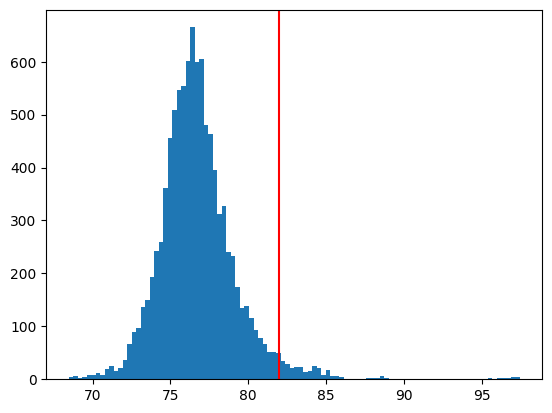

In [25]:
next(h)